### 1. Import packages and scripts

In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wntr
import random
import time
import pickle
from pipedream_kalman_filter_bwflnet import apply_EKF
import viswaternet as vis
import matplotlib.colors as mc
import matplotlib as mpl
from matplotlib.lines import Line2D

#Don't show future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2. Read INP file and specify estimation nodes and holdout nodes

In [2]:
inp = 'reduced_BWFLnet'
inp_path = f'./Networks/{inp}.inp'

In [3]:
wn = wntr.network.WaterNetworkModel(inp_path)

In [4]:
# Define list of boundary nodes
boundary_nodes = ['node_2012', 'node_0469', 'node_0468', 'node_0837', 'node_0836',
                     'node_1901', 'node_1900', 'node_0684', 'node_0683', 'node_1420', 'node_1421']

In [5]:
# Define list of junctions in network where sensors are placed
sensor_nodes = [ 'node_2210', 'node_1202','node_2046', 'node_2428', 'node_1781', 'node_1925']

In [6]:
# Estimation nodes: list of boundary nodes + junctions with sensors
estimation_nodes = sensor_nodes + boundary_nodes  

m = len(estimation_nodes)

In [7]:
# Holdout nodes
holdout_nodes = ['J-86', 'J-404', 'J-111', 'J-135']

all_pressure_sensors_list = ['node_1925', 'node_1938', 'node_1961', 'node_1971', 'node_1983',
                         'node_0354', 'node_2012', 'node_2046', 'node_2113', 'node_0785',
                         'node_2188', 'node_2197', 'node_2210', 'node_2243', 'node_2265',
                         'node_2285', 'node_1194', 'node_1202', 'node_2354', 'node_2428',
                         'node_2440', 'node_2441', 'node_1738', 'node_2485', 'node_1781',
                         'node_1876', 'node_2535']

holdout_nodes = [x for x in all_pressure_sensors_list if x not in estimation_nodes] 

### 3. Set up and run SE problem and extract results

In [8]:
dt = 900 # simulation time step [s]
t_run = 24 # simulation duration [hrs]

n = wn.num_nodes + wn.num_tanks # number of junctions in pipedream model. Extra junctions added to turn on/ off tank access

sensor_std_dev = 0.1
Rcov = 0.5**2 * np.eye(m) # uncertainty for state equation
Qcov = 10 * np.eye(n) # uncertainty for observation equation

In [9]:
t1 = time.time()
H_df_kf, H_df_model, model, Q_pump_model, Q_pump_ekf, Q_prv_model, Q_prv_ekf, measurements, Q_df_model, Q_df_filtered = apply_EKF(inp_path, estimation_nodes, 
                                                                                                                                  t_run=t_run, dt=dt,
                                                                                                                                  banded=False, Rcov=Rcov, Qcov=Qcov, sensor_std_dev=sensor_std_dev, num_iter=40)

t2 = time.time()
print('total time:', t2-t1)


total time: 255.41774201393127


In [10]:
%matplotlib inline

### 4. Read in sensor measurements 

In [11]:
sensor_info = pd.read_csv('Networks/bwflnet-_-data/data/sensor_info.csv')
logger_dict = {}

for element in list(sensor_info['Node/Link']):
    logger_dict[element] = sensor_info['Logger_ID'].loc[sensor_info['Node/Link']==element].values[0]

measurements = pd.DataFrame(columns = all_pressure_sensors_list + boundary_nodes, dtype=object) #, index = np.linspace(0,t_run*3600, t_run*4+1))
            
for sensor_name in all_pressure_sensors_list + boundary_nodes:
    logger = logger_dict[sensor_name]
    meas_data_all = pd.read_csv(f'Networks/bwflnet-_-data/data/15min/24hr_training_data/{logger}.csv')
    measurements[sensor_name] = meas_data_all['p_mean'].loc[:t_run*4] + wn.get_node(sensor_name).elevation

measurements.index = np.linspace(0,t_run*3600, t_run*4+1)
        

In [12]:
holdout_sensors = ['node_1925', 'node_1938', 'node_1961', 'node_1971', 'node_1983',
                         'node_0354', 'node_2012', 'node_2046', 'node_2113', 'node_0785',
                         'node_2188', 'node_2197', 'node_2210', 'node_2243', 'node_2265',
                         'node_2285', 'node_1194', 'node_1202', 'node_2354', 'node_2428',
                         'node_2440', 'node_2441', 'node_1738', 'node_2485', 'node_1781',
                         'node_1876', 'node_2535']

critical_sensors_list = ['node_0469', 'node_0468', 'node_0837', 'node_0836', 'node_1901', 'node_1900',
                    'node_1420', 'node_1421','node_0684', 'node_0683', 'node_2012']

filter_sensors_list = [ 'node_2210', 'node_1202',
                           'node_2046', 'node_2428', 'node_1781', 'node_1925']

holdout_sensors_list = [x for x in holdout_sensors if x not in critical_sensors_list+ filter_sensors_list]

### 5. Compare time series for measurements, model predictions, EKF estimates, and real pressure heads (Fig S2 in the SI)

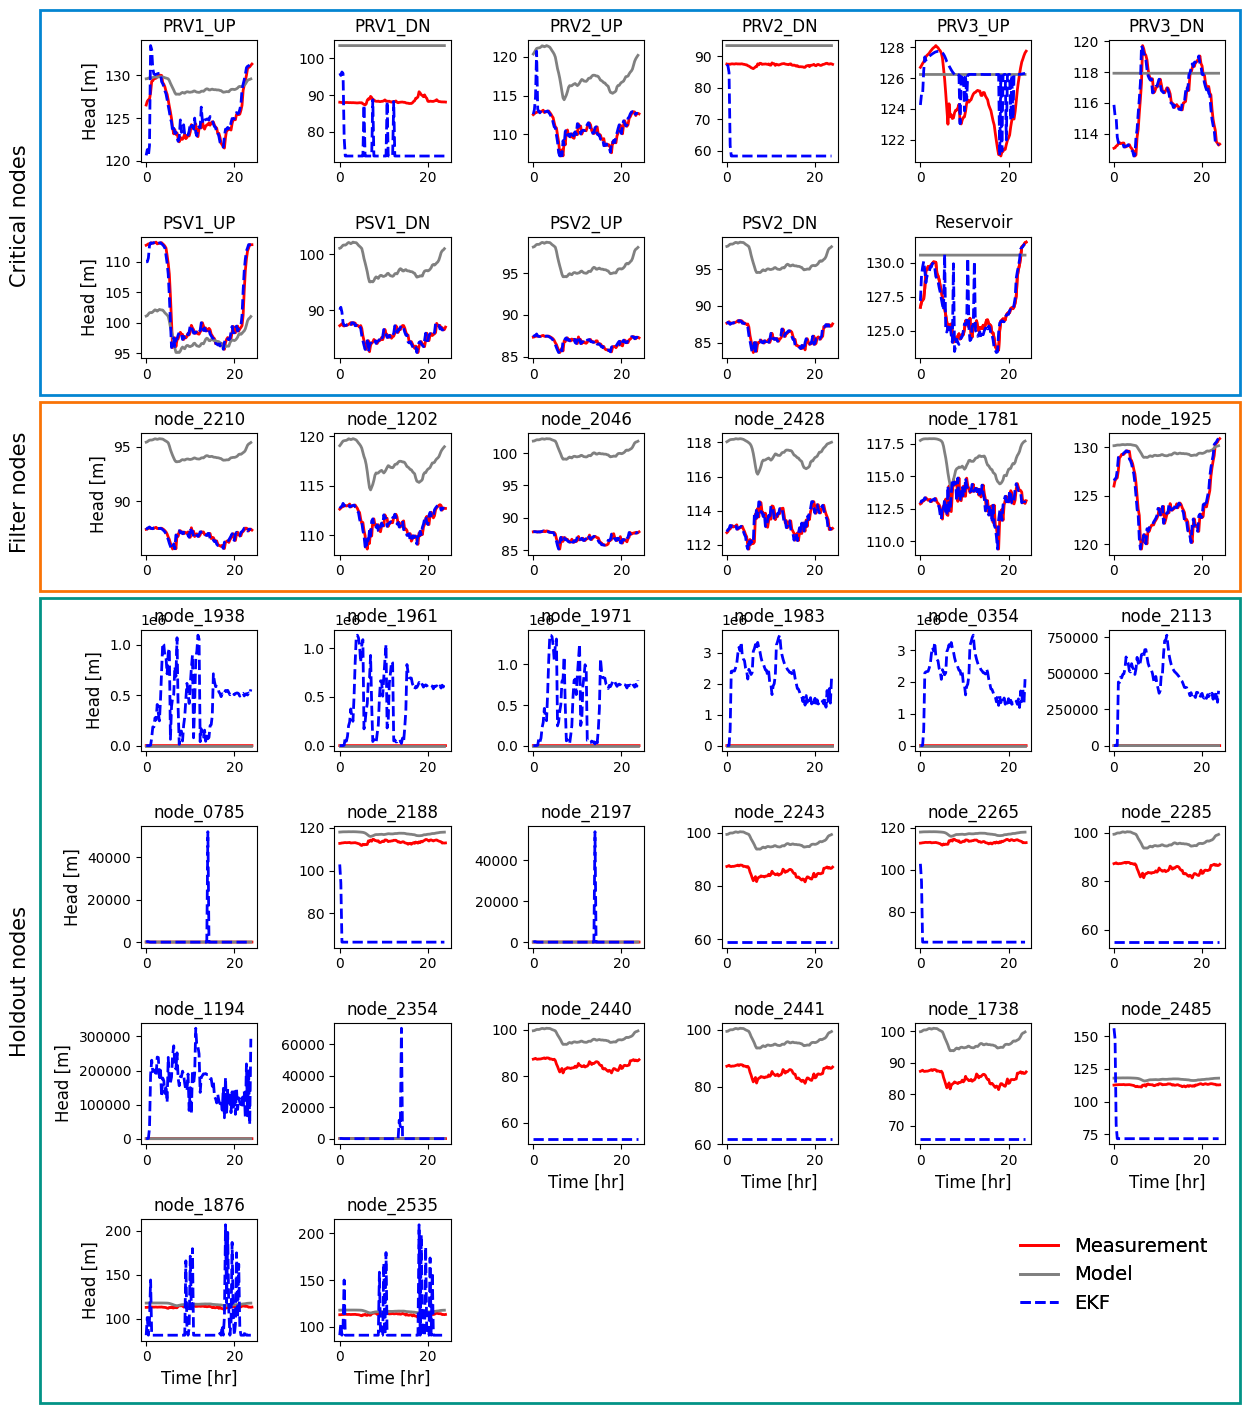

In [13]:
# plot pipedream and wntr heads 

critical_titles = ['PRV1_UP', 'PRV1_DN', 'PRV2_UP', 'PRV2_DN','PRV3_UP', 'PRV3_DN','PSV1_UP', 'PSV1_DN','PSV2_UP', 'PSV2_DN','Reservoir']

n_cols = 6
n_rows = int(np.ceil((len(filter_sensors_list )/ n_cols))) + int(np.ceil((len(critical_sensors_list )/ n_cols))) + int(np.ceil((len(holdout_sensors_list )/ n_cols)))
if n_rows==0:
    n_rows = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,  12 * n_rows / n_cols))
    

for index, name in enumerate(critical_sensors_list) :# + prv_nodes + psv_nodes):
    row = int(index//6)
    col = index%6
    ax[row][col].plot(measurements[name].index / 3600, measurements[name].values, c='r', linewidth=2, label='Measurement')
    ax[row][col].set_title(critical_titles[index], size=12)    
    ax[row][col].plot(H_df_model[name].index / 3600, H_df_model[name].values, c='gray',linewidth=2, label='Model')
    ax[row][col].plot(H_df_kf[name].index / 3600, H_df_kf[name].values,  c='b', linestyle = '--', linewidth=2, label='EKF')
    if col == 0:
        ax[row][col].set_ylabel('Head [m]', size=12)
    
for index, name in enumerate(filter_sensors_list) :# + prv_nodes + psv_nodes):
    row = int(np.ceil((len(critical_sensors_list )/ n_cols))) + int(index//6)
    col = index%6
    ax[row][col].plot(measurements[name].index / 3600, measurements[name].values, c='r', linewidth=2, label='Measurement')
    ax[row][col].set_title(name, size=12)    
    ax[row][col].plot(H_df_model[name].index / 3600, H_df_model[name].values, c='gray',linewidth=2, label='Model')
    ax[row][col].plot(H_df_kf[name].index / 3600, H_df_kf[name].values,  c='b', linestyle = '--', linewidth=2, label='EKF')
    if col == 0:
        ax[row][col].set_ylabel('Head [m]', size=12)
    
for index, name in enumerate(holdout_sensors_list) :# + prv_nodes + psv_nodes):
    row = int(np.ceil((len(critical_sensors_list )/ n_cols))) + int(np.ceil((len(filter_sensors_list )/ n_cols))) + int(index//6)
    col = index%6
    ax[row][col].plot(measurements[name].index / 3600, measurements[name].values, c='r', linewidth=2, label='Measurement')
    ax[row][col].set_title(name, size=12)    
    ax[row][col].plot(H_df_model[name].index / 3600, H_df_model[name].values, c='gray',linewidth=2, label='Model')
    ax[row][col].plot(H_df_kf[name].index / 3600, H_df_kf[name].values,  c='b', linestyle = '--', linewidth=2, label='EKF')
    if col == 0:
        ax[row][col].set_ylabel('Head [m]', size=12)
    if row == n_rows -1 :
        ax[row][col].set_xlabel('Time [hr]', size=12)
    if row == n_rows - 2 and col > 1:
        ax[row][col].set_xlabel('Time [hr]', size=12)


ax[1][5].set_visible(False)
ax[6][2].set_visible(False)
ax[6][3].set_visible(False)
ax[6][4].set_visible(False)
ax[6][5].axis('off')

# Legend
custom_lines2 = [Line2D([0], [0], color='r', lw=2),
                 Line2D([0], [0], color='gray',  lw=2),
                 Line2D([0], [0], color='b', lw=2, linestyle = '--')]
leg_labels2 = ['Measurement', 'Model', 'EKF']

legend2 = ax[6][5].legend(custom_lines2, leg_labels2, 
                    fontsize='14', frameon=False)
ax[6][5].add_artist(legend2)

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.00, 0.72), 1.00, 0.275, fill=False, color="xkcd:cerulean", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.00, 0.58), 1.00, 0.135, fill=False, color="xkcd:orange", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.00, 0.0), 1.00, 0.575, fill=False, color="xkcd:teal", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

#Adjust the subplot parameters to add white space
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

fig.text(-0.025, 0.8, 'Critical nodes',
         fontsize = 15,
         rotation=90, 
        )

fig.text(-0.025, 0.61, 'Filter nodes',
         fontsize = 15,
         rotation=90, 
        )

fig.text(-0.025, 0.25, 'Holdout nodes',
         fontsize = 15,
         rotation=90, 
        )

fig.tight_layout(h_pad =2)

plt.savefig('bwflnet_unconstrained_augmented_timeseries.pdf', bbox_inches = 'tight')

In [14]:
err = []
mod_holdout = []

for name in holdout_sensors_list:
    #if name not in prv_nodes and name not in psv_nodes:
    mod_holdout.append(name)
    err.append(np.mean(abs(measurements[name] - H_df_kf[name])))

### 6. Plot mean absolute deviation (MAD) between real and EKF estimated pressure heads at all nodes

C:\Software\Anaconda\Temp\ipykernel_11172\1541831215.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


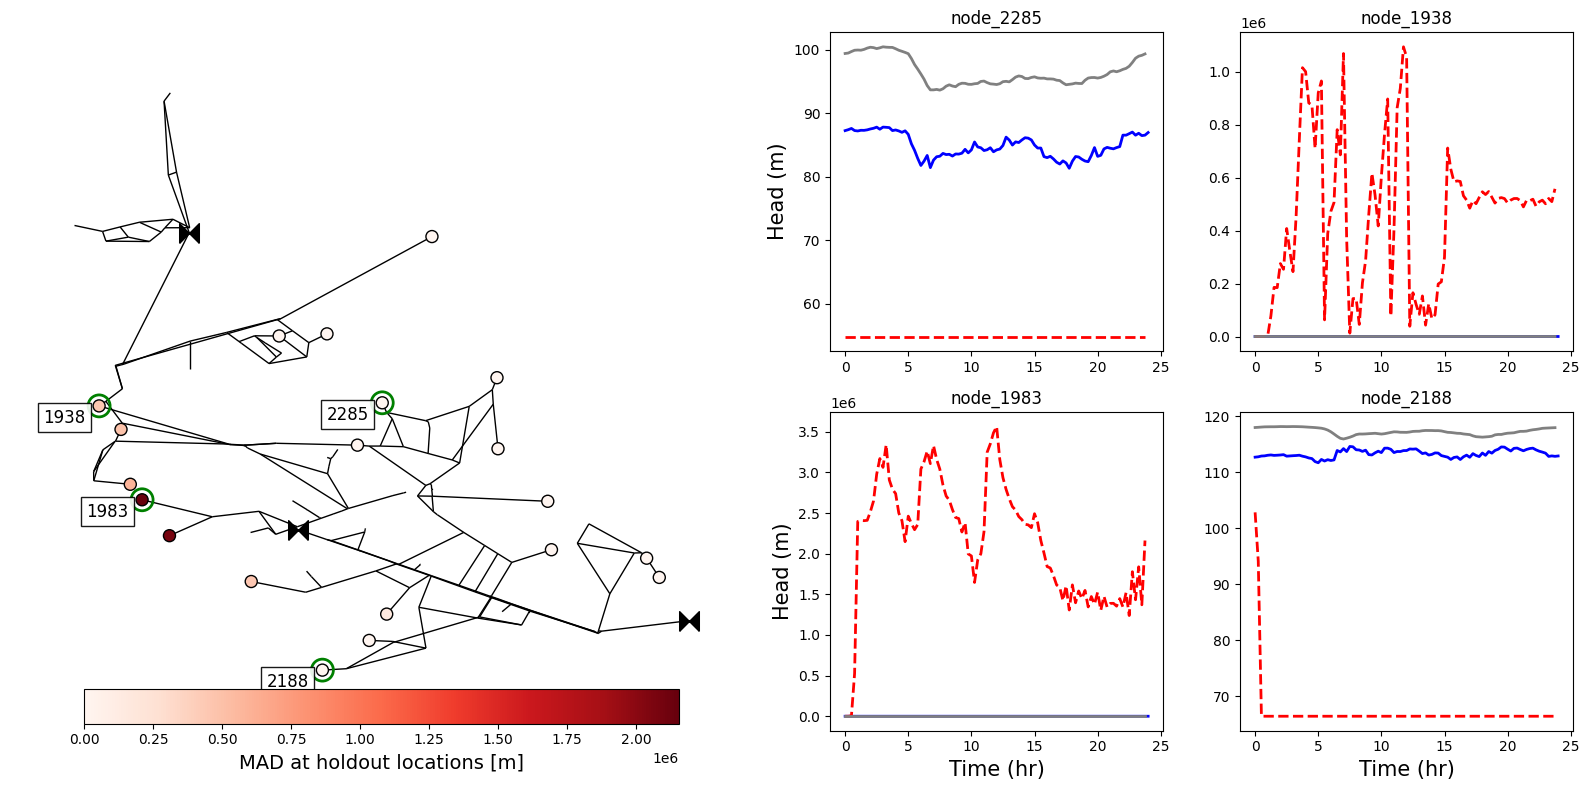

In [15]:
# this is the new one
model = vis.VisWNModel(inp_path)
xval = measurements['node_1971'].index / 3600

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

fs = 15
node_size = 200

ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=2, rowspan = 3)
  
ax1.set_frame_on(False) 
#node_size = 100
style = vis.NetworkStyle(cmap = 'Reds', node_border_width = 1,node_border_color = 'k', vmin = 0, 
                       draw_base_legend=False, draw_reservoirs = False, node_size = 300)
model.plot_unique_data(ax=ax1, parameter = "custom_data", parameter_type = 'node', 
                       custom_data_values = [mod_holdout, err], data_type = 'continuous',
                       style = style)
label_nodes = [ 'node_2285', 'node_1938',  'node_1983', 'node_2188']
labels = [ '2285', '1938',  '1983', '2188']
model.draw_label(ax=ax1, draw_nodes=label_nodes, labels= labels, x_coords=[-2000]*6, y_coords=[-2000]*6, label_font_size = 12)
model.draw_nodes(ax=ax1,  node_list = label_nodes,                
                 node_color = "None", node_size = 1000, 
                 node_border_width = 2, node_border_color = 'g')
                 
# valve start nodes
ax4 = plt.subplot2grid(shape=(2, 4), loc=(0, 2))
ax5 = plt.subplot2grid(shape=(2, 4), loc=(0, 3))
# valve end nodes
ax6 = plt.subplot2grid(shape=(2, 4), loc=(1, 2))
ax7 = plt.subplot2grid(shape=(2, 4), loc=(1, 3))

ax_list = [ax4, ax5, ax6, ax7]
node_list = label_nodes
names = labels
    
for i, ax in enumerate(ax_list):
    ax.plot(xval, measurements[node_list[i]].values, c='b', linewidth=2, label='Sensor reading')
    ax.set_title(node_list[i])
    ax.plot(H_df_kf[node_list[i]].index / 3600, H_df_kf[node_list[i]].values,  c='r', linestyle = '--', linewidth=2, label='EKF')
    ax.plot(H_df_model[node_list[i]].index / 3600, H_df_model[node_list[i]].values, c='gray',linewidth=2, label='Model')

ax4.set_ylabel('Head (m)', size=fs)
ax6.set_ylabel('Head (m)', size=fs)
ax6.set_xlabel('Time (hr)', size=fs)
ax7.set_xlabel('Time (hr)', size=fs)
    
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(ax1,
              height="5%", # set height
              width="80%", # and width
              loc=8) 
cmap = mpl.cm.Reds
norm = mpl.colors.Normalize(vmin=0, vmax=max(err))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('MAD at holdout locations [m]', fontsize=14)

plt.tight_layout()

plt.savefig('bwflnet_unconstrained_baseline_network.pdf', bbox_inches = 'tight')